In [1]:
%load_ext autoreload

In [2]:
import numpy as np 
import time 
import torch
import torch.nn as nn

In [3]:
from data import generate_one_batch, generate_one_sinusoidal_dataset
from models import InnerLoop, SinusoidalNet, MetaLearner

In [4]:
import matplotlib.pyplot as plt 
import matplotlib
%matplotlib inline 
matplotlib.style.use('ggplot')

Text(0.5, 1.0, 'Samples of sinusoidal functions')

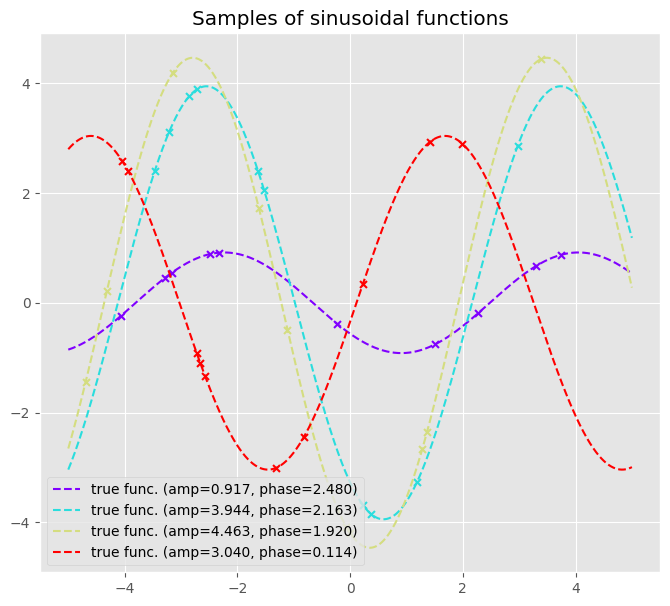

In [5]:
fig, ax = plt.subplots(1, figsize=(8, 7))

K = 10
xs = np.linspace(-5, 5, 10000)

n_trials = 4
colors = plt.cm.rainbow(np.linspace(0, 1, n_trials))
for trial_idx in range(n_trials):
    amplitude = np.random.uniform(0.1, 5.0)
    phase = np.random.uniform(0, np.pi)
    
    true_values = amplitude * np.sin(xs - phase)
    sample_xs, sample_ys = generate_one_sinusoidal_dataset(xs, amplitude, phase, K)
    
    ax.plot(xs, true_values, label=f'true func. (amp={amplitude:.3f}, phase={phase:.3f})', color=colors[trial_idx], ls='--', lw=1.5)
    ax.scatter(sample_xs, sample_ys, color=colors[trial_idx], marker='x', s=25)
    
plt.legend(loc='best')    
ax.set_title('Samples of sinusoidal functions')
    
    
    

In [6]:
def make_model(config):
    model = MetaLearner(
        config['meta_batch_size'],
        config['meta_step_size'],
        config['inner_step_size'],
        config['num_updates'],
        config['num_inner_updates'],
        nn.MSELoss(reduction='mean'),
        config['input_dim'],
        config['hidden_dim'],
        config['p_drop'],        
    )
    return model 


In [7]:
config = {    
    'meta_batch_size': 1000,
    'meta_step_size': 1e-3,
    'inner_step_size': 5e-2,
    'num_updates': 3,
    'num_inner_updates': 5,
    'input_dim': 1,
    'hidden_dim': 40,
    'p_drop': 0.01,
    'save_path': './maml_test.pth'    
}

In [8]:
model = make_model(config)

In [9]:
num_episodes = 500
support_size = 10
query_size = 10
meta_batch_size = config['meta_batch_size']

In [10]:
start_time = time.time()

rmse_list = []
min_rmse = None
for episode in range(num_episodes):
    support_x_list, support_y_list, query_x_list, query_y_list, true_data = generate_one_batch(support_size, query_size, meta_batch_size)
    
    batch_rmse = model.train(support_x_list, support_y_list, query_x_list, query_y_list)
    if min_rmse is None or batch_rmse < min_rmse:
        min_rmse = batch_rmse
        print(f'min_rmse: {min_rmse:.3f}')
        model.save_model(config['save_path'])
    rmse_list.append(batch_rmse)

time_elapsed = (time.time() - start_time) / 60
print(f'time elapsed: {time_elapsed:.2f} minutes')


min_rmse: 2.141
min_rmse: 2.082
min_rmse: 2.031
min_rmse: 2.011
min_rmse: 1.991
min_rmse: 1.981
min_rmse: 1.978
min_rmse: 1.941
min_rmse: 1.929
min_rmse: 1.877
min_rmse: 1.854
min_rmse: 1.851
min_rmse: 1.829
min_rmse: 1.774
min_rmse: 1.745
min_rmse: 1.685
min_rmse: 1.648
min_rmse: 1.626
min_rmse: 1.621
min_rmse: 1.598
min_rmse: 1.592
min_rmse: 1.590
min_rmse: 1.576
min_rmse: 1.567
min_rmse: 1.542
min_rmse: 1.517
min_rmse: 1.493
min_rmse: 1.476
min_rmse: 1.466
min_rmse: 1.461
min_rmse: 1.459
min_rmse: 1.415
min_rmse: 1.405
min_rmse: 1.367
min_rmse: 1.338
min_rmse: 1.336
min_rmse: 1.326
min_rmse: 1.306
min_rmse: 1.283
min_rmse: 1.281
min_rmse: 1.268
min_rmse: 1.266
min_rmse: 1.248
min_rmse: 1.239
min_rmse: 1.229
time elapsed: 128.95 minutes


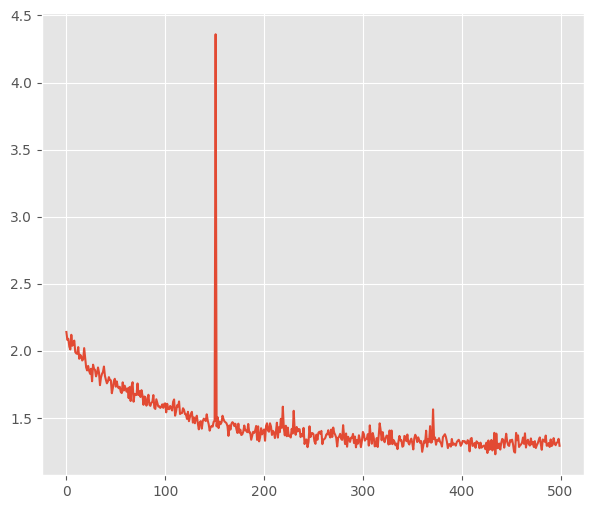

In [11]:
fig, ax = plt.subplots(1, figsize=(7, 6))
ax.plot(range(num_episodes), rmse_list, lw=1.5)


#### See how do the predictions change as a function of fine-tuning steps

In [12]:
support_x_list, support_y_list, _query_x_list, _query_y_list, true_data = generate_one_batch(support_size=7, query_size=7, batch_size=1)
support_x = support_x_list[0]
support_y = support_y_list[0]

true_amplitude, true_phase = true_data[0]

query_x1 = np.linspace(-5, 5, 1000)
query_y1 = true_amplitude * np.sin(query_x1 - true_phase)

query_x1 = torch.tensor(query_x1).reshape((len(query_x1), 1)).float()
query_y1 = torch.tensor(query_y1).float()



In [13]:
all_preds = []
fine_tune_steps_list = [0, 5, 10, 20, 100]
for fine_tune_steps in fine_tune_steps_list:
    model1 = make_model(config)
    model1.load_model(config['save_path'])
    if fine_tune_steps == 0:
        preds = model1.net(query_x1)
    else:
        preds = model1.fine_tune_and_predict(support_x, support_y, query_x1, fine_tune_steps)
    
    all_preds.append(preds)
    

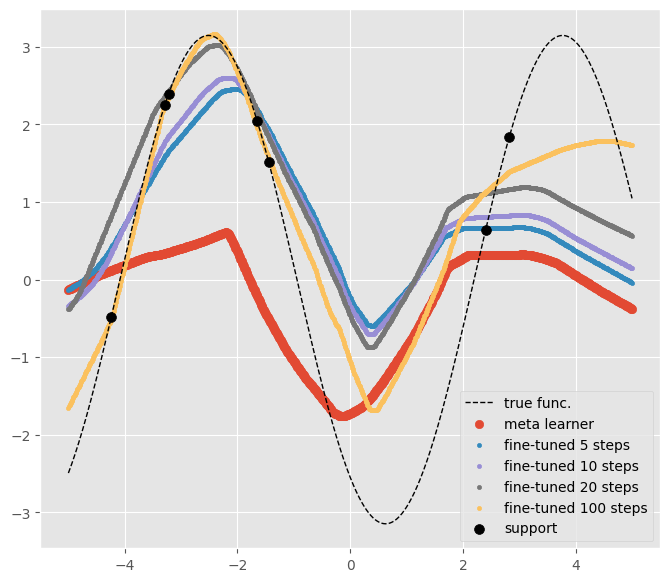

In [14]:
fig, ax = plt.subplots(1, figsize=(8, 7))

xvals = query_x1.detach().squeeze(1).numpy()
yvals = query_y1.detach().numpy()

ax.plot(xvals, yvals, color='k', lw=1, ls='--', label='true func.')

for fine_tune_steps, preds in zip(fine_tune_steps_list, all_preds):
    if fine_tune_steps == 0:
        ax.scatter(xvals, preds.detach().numpy(), label='meta learner')
    else:
        ax.scatter(xvals, preds.detach().numpy(), label=f'fine-tuned {fine_tune_steps} steps', marker='.')
ax.scatter(support_x.detach().squeeze(1).numpy(), support_y.numpy(), color='k', s=50, label='support')

ax.legend(loc='best', fontsize=10)
